In [159]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [160]:
class SincDataset(Dataset):
    def __init__(self, filename):
        xy = np.loadtxt(filename, delimiter=',', dtype=np.float32)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:, :-1]) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(xy[:, [-1]]) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [161]:
# create dataset
dataset = SincDataset('.data/sinc_data.txt')
print(len(dataset))

20000


In [162]:
generator2 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2], generator=generator2)

# Autoencoder

In [163]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import lightning as L

In [164]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(
    nn.Linear(1000, 500), 
    nn.ReLU(), 
    nn.Linear(500, 250), 
    nn.ReLU(),
    nn.Linear(250, 100), 
    nn.ReLU(),
    nn.Linear(100, 50), 
    nn.ReLU(),
    nn.Linear(50, 20), 
    nn.ReLU(),
    nn.Linear(20, 10),
    )
decoder = nn.Sequential(
    nn.Linear(10, 20), 
    nn.ReLU(),
    nn.Linear(20, 50), 
    nn.ReLU(),
    nn.Linear(50, 100), 
    nn.ReLU(),
    nn.Linear(100, 250), 
    nn.ReLU(),
    nn.Linear(250, 500), 
    nn.ReLU(),
    nn.Linear(500, 1000), 
    nn.Tanh(),
    )


In [165]:
# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", test_loss)
    

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [166]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=11)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=11)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=11)

In [167]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=100, callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 657 K 
1 | decoder | Sequential | 658 K 
---------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.261     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [168]:
# load checkpoint
checkpoint = "./lightning_logs/version_7/checkpoints/epoch=12-step=39000.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
trained_encoder = autoencoder.encoder
trained_decoder = autoencoder.decoder
encoder.eval()


Sequential(
  (0): Linear(in_features=1000, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=20, bias=True)
  (9): ReLU()
  (10): Linear(in_features=20, out_features=10, bias=True)
)

In [169]:
trainer.test(model=autoencoder, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         3.5263631161797093e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.5263631161797093e-06}]

In [176]:

# embed 4 fake images!
fake_x, fake_y = test_dataset[16]
recon = autoencoder.forward(fake_x)
tlist = np.linspace(-5,5,  1000)
fig, ax = plt.subplots()
ax.plot(tlist, fake_x.cpu().numpy(), label='Signal')
ax.plot(tlist, recon, label='Reconstruction')
ax.legend()
ax.set(xlim=(-2,2), xlabel=r't ($\tau$)', ylabel='Signal Amplitude', title=fr'separation = {fake_y.detach().numpy()[0]:.2f} $\tau$')
print(f"Loss = {nn.functional.mse_loss(torch.tensor(recon), fake_x):.2e}")


NotImplementedError: Module [LitAutoEncoder] is missing the required "forward" function

In [171]:
import numpy as np
from tqdm.auto import tqdm

In [172]:
vis = np.asarray([(float(fake_y), float(nn.functional.mse_loss(trained_decoder(trained_encoder(fake_x)),fake_x))) for fake_x, fake_y in tqdm(test_dataset)])
vis  = vis[vis[:, 0].argsort()]

  0%|          | 0/4000 [00:00<?, ?it/s]

[Text(0.5, 0, 'Separation $(\\tau)$'),
 Text(0, 0.5, 'Reconstruction Loss (MSE)'),
 Text(0.5, 1.0, 'Reconstruction Loss vs Test Separation'),
 (0.0, 2.0),
 (1e-08, 1e-05)]

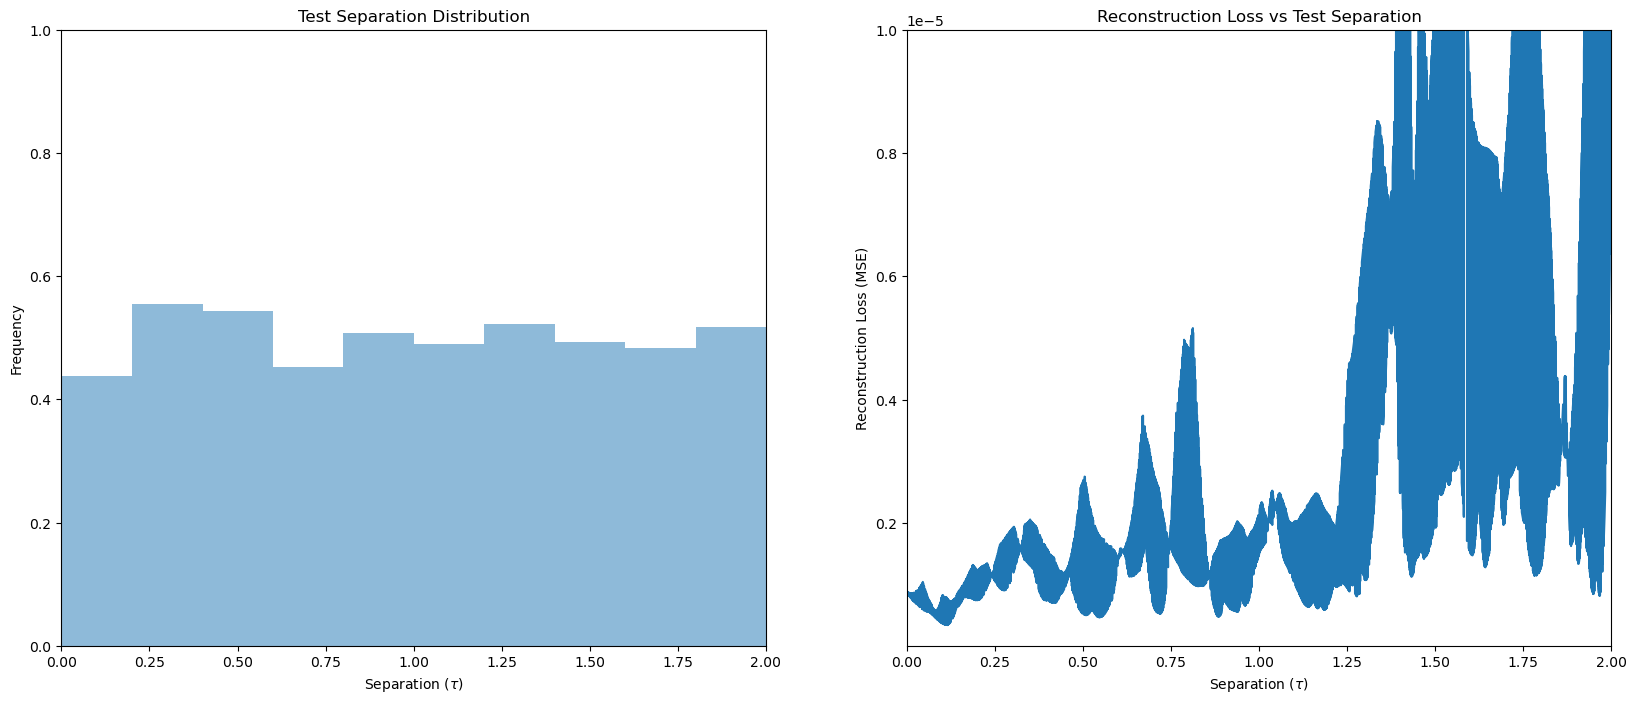

In [173]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 8))
ax[0].hist(y_list, bins=10, alpha=0.5, label='Test', density=True);
ax[0].set(xlabel=r'Separation $(\tau)$', ylabel='Frequency', title='Test Separation Distribution', ylim=(0,1))
ax[1].plot(vis[:, 0], vis[:, 1])
ax[1].set(xlabel=r'Separation $(\tau)$', ylabel='Reconstruction Loss (MSE)', title='Reconstruction Loss vs Test Separation', xlim=(0,2), ylim=(1e-8, 1e-5))

In [174]:
fig, ax = plt.subplots()

ax
ax.

SyntaxError: invalid syntax (47845829.py, line 4)

In [ ]:
y_list = (test_dataset[:][ -1]).detach().numpy()
np.argwhere(y_list[:100]<0.2)

array([[16,  0],
       [36,  0],
       [49,  0],
       [65,  0],
       [79,  0]])